## Importing required library

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm_notebook, tnrange
from tqdm import tqdm

## Reading CSV file[](http://)

In [2]:
main_ship_data = pd.read_csv("../input/airbus-ship-detection/train_ship_segmentations_v2.csv")

In [3]:
main_ship_data["has_ship"] = main_ship_data["EncodedPixels"].map(lambda x:1 if isinstance(x,str) else 0)

In [4]:
main_ship_data.head()

,ImageId,EncodedPixels,has_ship
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1


## Preprocessing of data

In the original ship data there are many duplicate Image_Id, because an image with 5 ships in it will have 5 different bounding boxes and so on. So creating a dataframe with unique Image_Id so that we can have a better visualisation and understanding.

In [5]:
unique_ship_data = main_ship_data.groupby("ImageId").agg({"has_ship":sum}).reset_index()
unique_ship_data["number_of_ships"] = unique_ship_data["has_ship"]
unique_ship_data.drop("has_ship", axis = 1, inplace = True)

unique_ship_data["has_ship"] = unique_ship_data["number_of_ships"].map(lambda x:1.0 if x>=1.0 else 0)

In [6]:
unique_ship_data.head()

,ImageId,number_of_ships,has_ship
0,00003e153.jpg,0,0.0
1,0001124c7.jpg,0,0.0
2,000155de5.jpg,1,1.0
3,000194a2d.jpg,5,1.0
4,0001b1832.jpg,0,0.0


## Decoding the Encodedpixels

Defined a function, which converts the encodedpixels to X_center, Y_center, Height, Width of the bounding box.

*Here Encodedpixels are in the Run-length encoding format, which is a form of lossless data compression in which runs of data are stored as a single data value and count, rather than as the original run.*

In [7]:
def rle2bbox(rle, shape):
   
   a = np.fromiter(rle.split(), dtype=np.uint)
   a = a.reshape((-1, 2))  # an array of (start, length) pairs
   a[:,0] -= 1  # `start` is 1-indexed
   
   y0 = a[:,0] % shape[0]
   y1 = y0 + a[:,1]
   if np.any(y1 > shape[0]):
       # got `y` overrun, meaning that there are a pixels in mask on 0 and shape[0] position
       y0 = 0
       y1 = shape[0]
   else:
       y0 = np.min(y0)
       y1 = np.max(y1)
   
   x0 = a[:,0] // shape[0]
   x1 = (a[:,0] + a[:,1]) // shape[0]
   x0 = np.min(x0)
   x1 = np.max(x1)
   
   if x1 > shape[1]:
       # just went out of the image dimensions
       raise ValueError("invalid RLE or image dimensions: x1=%d > shape[1]=%d" % (
           x1, shape[1]
       ))
    
   xC = (x1+x0)/(2*768)
   yC = (y1+y0)/(2*768)
   h = np.abs(y1-y0)/768
   w = np.abs(x1-x0)/768

   return [xC, yC, h, w]

In [8]:
main_ship_data["bbox"] = main_ship_data["EncodedPixels"].map(lambda x: rle2bbox(x, (768,768)) if isinstance(x,str) else np.NaN )
main_ship_data.drop("EncodedPixels", axis=1, inplace = True)

In [9]:
#Creating a new column with the area of bounding box in it.
main_ship_data["bboxArea"]=main_ship_data["bbox"].map(lambda x:x[2]*768*x[3]*768 if x==x else 0)

In [10]:
main_ship_data.head()

,ImageId,has_ship,bbox,bboxArea
0,00003e153.jpg,0,NaN,0.0
1,0001124c7.jpg,0,NaN,0.0
2,000155de5.jpg,1,"[0.5149739583333334, 0.62890625, 0.046875, 0.1...",3708.0
3,000194a2d.jpg,1,"[0.625, 0.38671875, 0.026041666666666668, 0.02...",440.0
4,000194a2d.jpg,1,"[0.09830729166666667, 0.4967447916666667, 0.01...",153.0


## Exploratory Data Analysis and Visualization

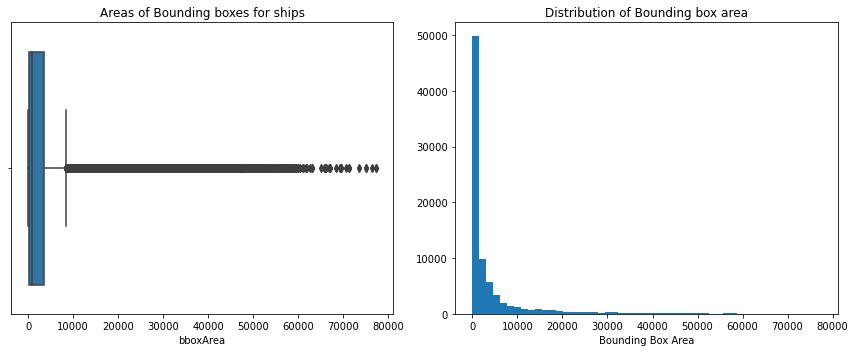

In [11]:
# Plotting the distribution of the bounding box areas to check the ship sizes

area = main_ship_data[main_ship_data["has_ship"]>0]

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
sns.boxplot(area["bboxArea"])
plt.title("Areas of Bounding boxes for ships")
# plt.xscale("log")
plt.subplot(1,2,2)
plt.hist(area["bboxArea"], bins=50)
# plt.xscale("log")
plt.title("Distribution of Bounding box area")
plt.xlabel("Bounding Box Area")
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


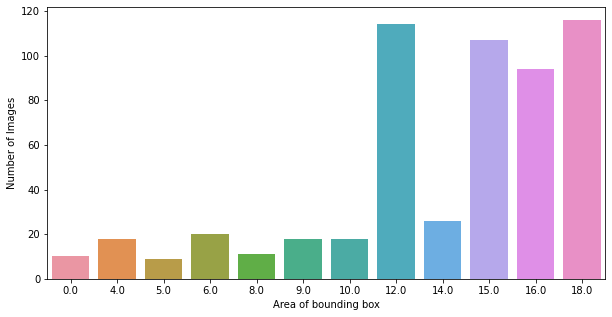

In [12]:
area = main_ship_data[(main_ship_data["has_ship"]>0)&(main_ship_data["bboxArea"]<20)]
area["bboxArea"] = np.round(area["bboxArea"])

plt.figure(figsize=(10,5))
sns.countplot(x="bboxArea", data=area)
plt.xlabel("Area of bounding box")
plt.ylabel("Number of Images")
plt.show()

* There are few bounding boxes with area less than 10 pixels and some have area equal to 0. So, removing these tiny boxes as they learn wrong features and may result in wrong prediction while testing. 

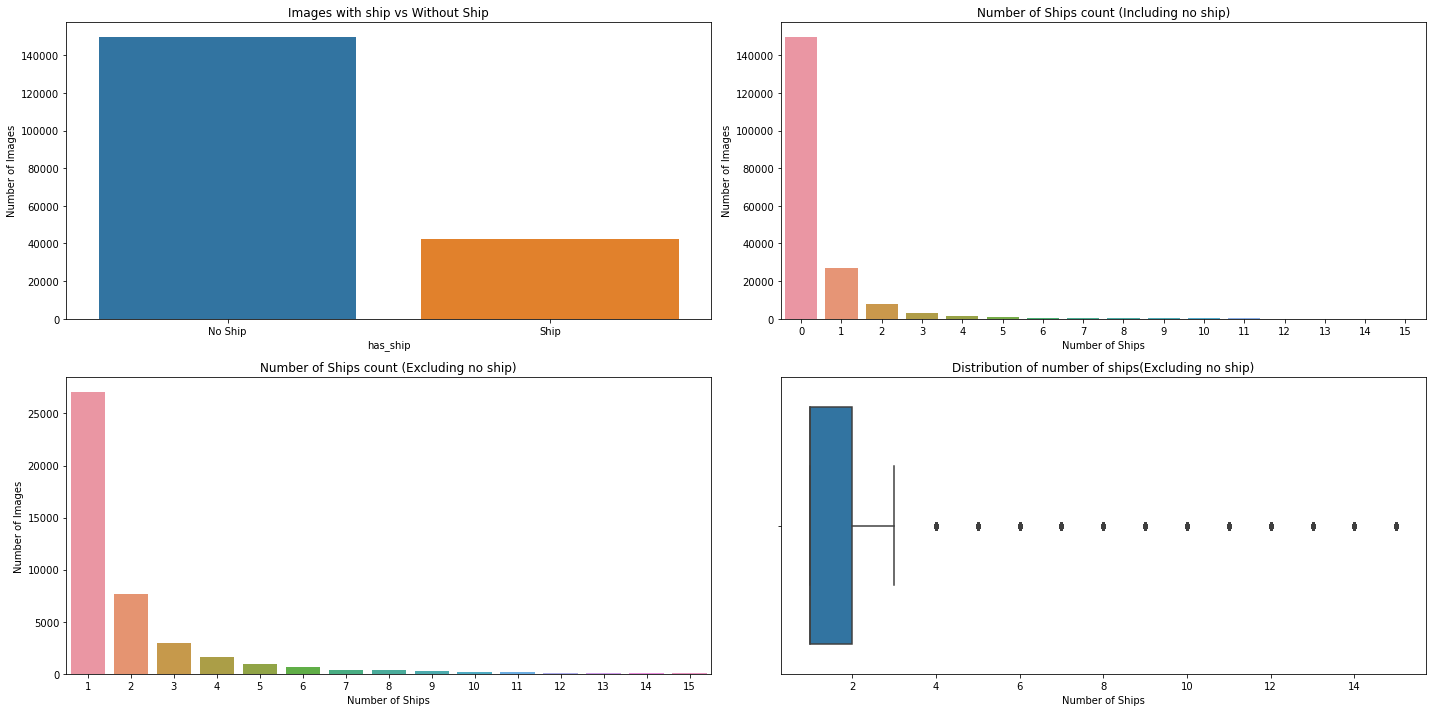

In [13]:
# Finding the distribution of no of ships

plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
classes=["No Ship","Ship"]
ax = sns.countplot(unique_ship_data["has_ship"])
ax.set_xticklabels(classes)
plt.ylabel("Number of Images")
plt.title("Images with ship vs Without Ship")

plt.subplot(2,2,2)
sns.countplot(unique_ship_data["number_of_ships"])
# plt.yscale("log")
plt.xlabel("Number of Ships")
plt.ylabel("Number of Images")
plt.title("Number of Ships count (Including no ship)")

withship = unique_ship_data[unique_ship_data["has_ship"]==1]
plt.subplot(2,2,3)
sns.countplot(withship["number_of_ships"])
plt.xlabel("Number of Ships")
plt.ylabel("Number of Images")
plt.title("Number of Ships count (Excluding no ship)")

plt.subplot(2,2,4)
sns.boxplot(withship["number_of_ships"])
plt.xlabel("Number of Ships")
plt.title("Distribution of number of ships(Excluding no ship)")

plt.tight_layout()

* Almost 75% of the images containing ships have ships less or equal to 3.
* Most of the images with ships contains 1 ship.
* There is a data imbalance for the no of ships in the Images.
* Most of the ships are very small in sizes although there are few images with significantly large ship sizes.

## Data preparation and creating a balance dataframe

After creating dataframe(unique_ship_data) with unique Image_Id, we found that the disribution of of image containing ship and the image not containing the ship is highly imbalanced and moreover it will be computionally expensive. So to train the model fast and efficently, we took the full data from kaggle and created a smaller balanced dataframe from it by taking 1000 images from every class of images(here class is number of ships in an image). There are total 16 classes including the image with no ship.

In [14]:
# Removing boxes which are less than 1 percentile
# main_ship_data = main_ship_data[(main_ship_data["bboxArea"]>10) & (main_ship_data["has_ship"]==1)]

main_ship_data = main_ship_data.drop(main_ship_data[(main_ship_data["bboxArea"]<10) & (main_ship_data["has_ship"]!=0)].index)

In [15]:
numberofships = 1000

balance_ship_data = unique_ship_data.groupby("number_of_ships").apply(lambda x:x.sample(numberofships) if len(x)>numberofships else x)
balance_ship_data = balance_ship_data.reset_index(drop = True)
balance_ship_data = balance_ship_data.drop("has_ship", axis=1)

In [16]:
balance_ship_data

,ImageId,number_of_ships
0,aad393042.jpg,0
1,7de450ff9.jpg,0
2,4d3bba8b1.jpg,0
3,e106870c9.jpg,0
4,29bc1d16f.jpg,0
...,...,...
8197,ea9f82665.jpg,15
8198,eec04e7a8.jpg,15
8199,f7e6819bb.jpg,15
8200,fd1de824c.jpg,15


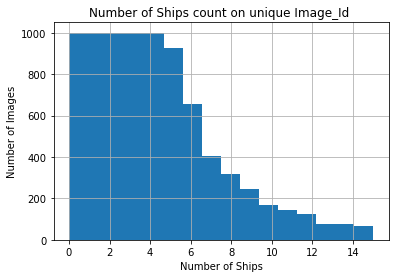

In [17]:
balance_ship_data["number_of_ships"].hist(bins=16)
plt.xlabel("Number of Ships")
plt.ylabel("Number of Images")
plt.title("Number of Ships count on unique Image_Id ")
plt.show()

In [18]:
# Merging the the balance_ship_data with main_ship_data in order to have the Encodedpixels
balance_ship_data = pd.merge(balance_ship_data, main_ship_data, on='ImageId')

In [19]:
balance_ship_data.sample(5)

,ImageId,number_of_ships,has_ship,bbox,bboxArea
22998,3c74edc8e.jpg,8,1,"[0.9016927083333334, 0.024739583333333332, 0.0...",990.0
31162,97d1ad270.jpg,12,1,"[0.869140625, 0.771484375, 0.02473958333333333...",361.0
21975,e20e64d5d.jpg,7,1,"[0.7115885416666666, 0.79296875, 0.0078125, 0....",90.0
7479,cd82d92dd.jpg,4,1,"[0.2845052083333333, 0.09700520833333333, 0.06...",3619.0
25134,182314e59.jpg,9,1,"[0.962890625, 0.8294270833333334, 0.0208333333...",592.0


## Exploratory Data Analysis for balance ship data

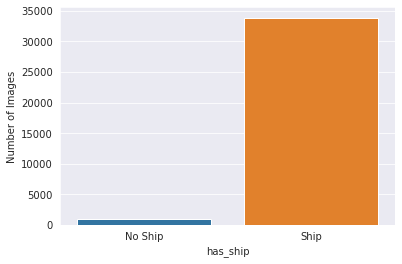

In [20]:
#Distrubution of count of images with ships and no ships in balance_ship_data dataframe
classes=["No Ship","Ship"]
sns.set_style('darkgrid')  
ax = sns.countplot(x="has_ship", data=balance_ship_data)
ax.set_xticklabels(classes)
plt.ylabel("Number of Images")
plt.show()

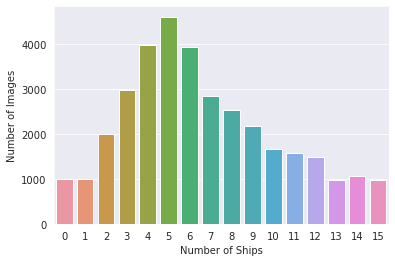

In [21]:
#Distrubution of number of ships in a single image in balance_ship_data dataframe
sns.set_style('darkgrid')  
ax = sns.countplot(x="number_of_ships", data=balance_ship_data)
# ax.set_xticklabels(classes)
plt.xlabel("Number of Ships")
plt.ylabel("Number of Images")
plt.show()

## Balance Data Image Visualization

In [22]:
#Defining a function to load image
def load_img(path):
    image = cv2.imread(path)
    return image[...,::-1]

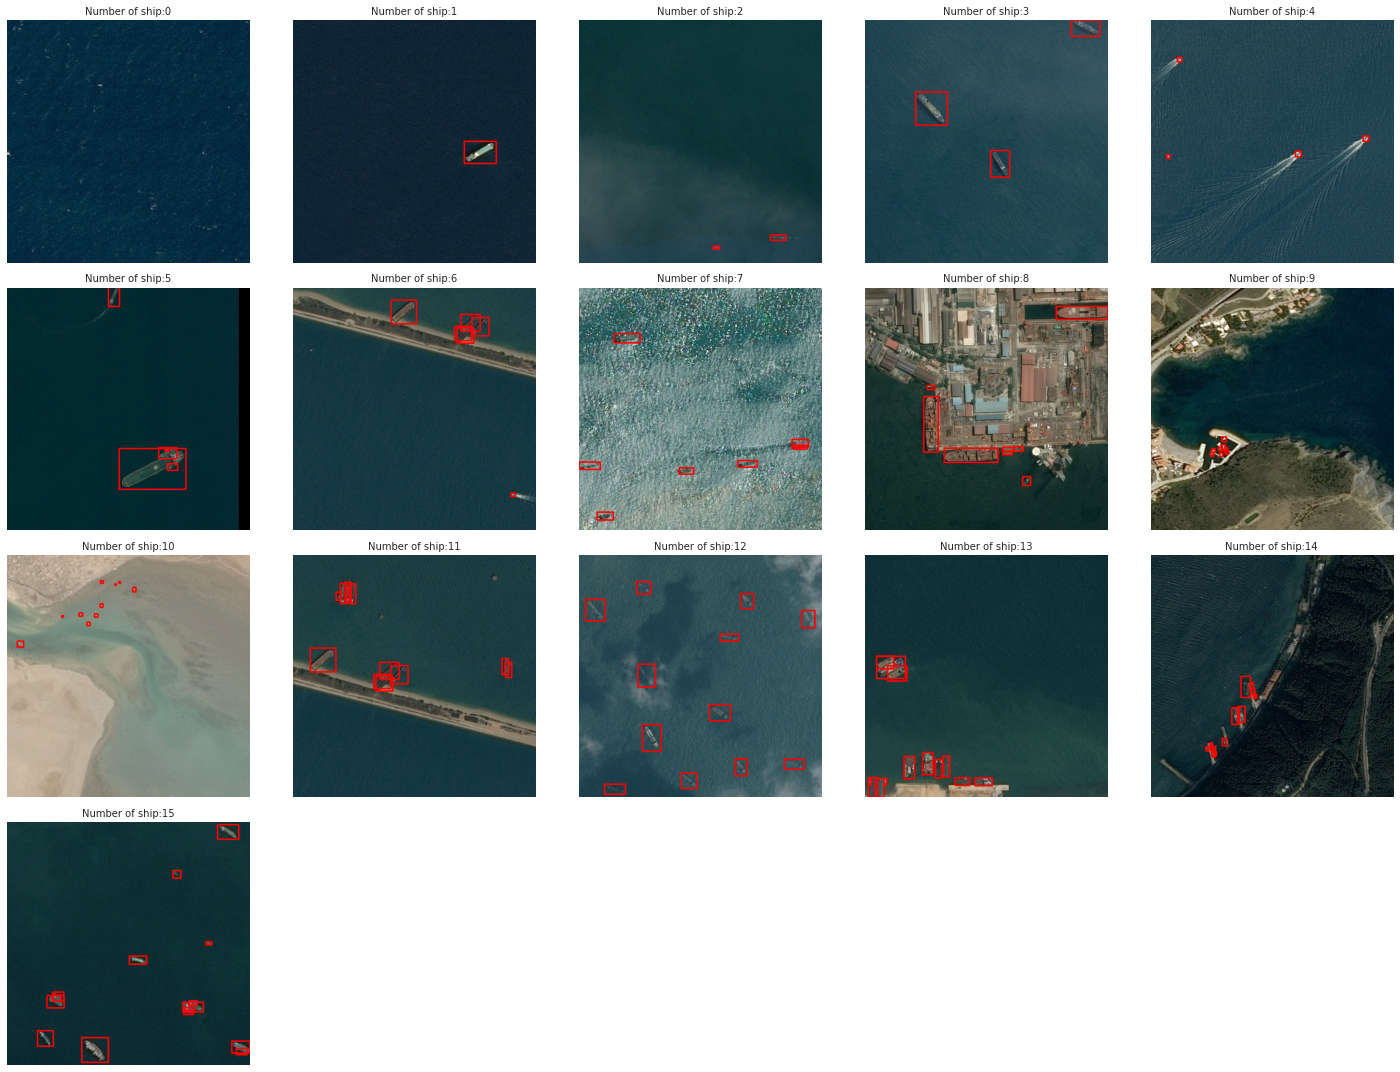

In [23]:
path = "../input/airbus-ship-detection/train_v2/"

plt.figure(figsize=(20, 15))

for i in range(16):
    
  imageid = balance_ship_data["ImageId"][balance_ship_data["number_of_ships"]==i].sample(5).reset_index(drop=True)    
  imageid = imageid[0]
  image = np.array(load_img(path+imageid))

  text = "Name of the image:{0}".format(imageid[0])
    
  Bbox = balance_ship_data["bbox"][balance_ship_data["ImageId"]==imageid].reset_index(drop=True)

  plt.subplot(4,5,i+1)
    
  if i>0:
    for j in Bbox:
      # print(i[0])
      xc = j[0]
      yc = j[1]
      h = j[2]
      w = j[3]

      x0 = int((xc-(w/2))*768)
      y0 = int((yc-(h/2))*768)
      x1 = int((xc+(w/2))*768)
      y1 = int((yc+(h/2))*768)

      cv2.rectangle(image,
            pt1=(x0,y0),
            pt2=(x1,y1),
            color=(255,0,0),
            thickness=3)
    
  plt.imshow(image)
  plt.title("Number of ship:{}".format(i),fontsize=10)
  plt.axis('off')
  
plt.tight_layout()
plt.show()

## Extracting the Bounding box coordinates into YOLO format

In [24]:
# folder_location = "/content/drive/My Drive/Colab_Notebooks/Capstone" ##Location of the folder which contains the train and test images

# for i, img_id in tqdm(enumerate(balance_ship_data["ImageId"])):

#     filt_df = balance_ship_data[balance_ship_data.ImageId==img_id]
#     all_boxes = filt_df.bbox.values
#     img_id = img_id.split(".")[0]
#     file_name = "{}/{}.txt".format(folder_location,img_id) 

#     s = "0 %s %s %s %s \n" 
#     with open(file_name, 'a') as file: 
#         if filt_df["has_ship"]>0:
#             for i in all_boxes:
#                 new_line = (s % tuple(i))
#                 file.write(new_line)

## Spliting the image data into train and test

In [25]:
# X = balance_ship_data[["ImageId"]]
# y = balance_ship_data["EncodedPixels"]

# train, test, _, _ = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [26]:
# path = "/content/Capstone/shipimages/" #path where ship images are there
# path_txt = "/content/Capstone/"        #path where you want the txt file to be created

# train["ImageId"] = path + train["ImageId"]
# test["ImageId"] = path +test["ImageId"]

## Extracting the path of train and test image data into .txt file

In [27]:
# train.to_csv(path_txt+"Train_path.txt",index=None, header=None, sep=" ", mode="a")
# test.to_csv(path_txt+"Test_path.txt",index=None, header=None, sep=" ", mode="a")